# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Dataset

In [2]:
df = pd.read_csv('data.csv')

In [3]:
# Looking at the data
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Preprocessing

In [4]:
# Removing columns that don't contribute to the model
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Converting object data types to numerical data types
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data_types_in_df = dict(df.dtypes)
for name, type in data_types_in_df.items():
    if type == "object":
        df[name] = le.fit_transform(df[name])

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


# Splitting Dataset

In [6]:
# Splitting dataset into feature sets and target sets
X = df.drop(["Exited"], axis=1).values
y = df["Exited"].values.astype(np.uint8)

# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=4)

# Size of training set
print(X_train.shape, y_train.shape)

(8000, 10) (8000,)


# Decision Tree Model

In [7]:
# Define a Node class to represent a node in the decision tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

# Define a DecisionTree class to represent the decision tree
class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    # Check if the decision tree is finished growing
    def _is_finished(self, depth):
        if (depth >= self.max_depth or self.n_class_labels == 1 or self.n_samples < self.min_samples_split):
            return True
        return False
    
    # Calculate entropy of a given set of labels
    def _entropy(self, y):
        proportions = np.bincount(y) / len(y)
        return sum(-p * np.log2(p) for p in proportions if p > 0)

    # Create a split based on a given threshold
    def _create_split(self, X, thresh):
        left_indices = np.argwhere(X <= thresh).flatten()
        right_indices = np.argwhere(X > thresh).flatten()
        return left_indices, right_indices

    # Calculate information gain of a given split
    def _information_gain(self, X, y, thresh):
        parent_loss = self._entropy(y)
        left_indices, right_indices = self._create_split(X, thresh)
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0
        n = len(y)
        n_left, n_right = len(left_indices), len(right_indices)
        e_left, e_right = self._entropy(y[left_indices]), self._entropy(y[right_indices])
        child_loss = (n_left / n) * e_left + (n_right / n) * e_right
        ig = parent_loss - child_loss
        return ig

    # Find the best split for a given set of features
    def _best_split(self, X, y, features):
        split = {'score': -1, 'feat': None, 'thresh': None}
        for feat in features:
            X_feat = X[:, feat]
            thresholds = np.unique(X_feat)
            for thresh in thresholds:
                ig = self._information_gain(X_feat, y, thresh)
                if ig > split['score']:
                    split['score'] = ig
                    split['feat'] = feat
                    split['thresh'] = thresh
        return split['feat'], split['thresh']
    
    # Build the decision tree recursivelyx
    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        #Stopping criteria
        if self._is_finished(depth):
            most_common_label = np.bincount(y).argmax()
            return Node(value=most_common_label)
        
        #get best split
        rnd_features = np.random.choice(self.n_features, self.n_features, replace=False)
        best_feat, best_thresh = self._best_split(X, y, rnd_features)

        #grow tree recursively
        left_indices, right_indices = self._create_split(X[:, best_feat], best_thresh)
        left_child = self._build_tree(X[left_indices, :], y[left_indices], depth+1)
        right_child = self._build_tree(X[right_indices, :], y[right_indices], depth+1)
        return Node(best_feat, best_thresh, left_child, right_child)
    
    # Traverse the decision tree to predict the label of a given sample
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
     
    # Fit the decision tree to the training data
    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    # Predict the labels of the test data
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    

# Training model
dt = DecisionTree(max_depth=10)
dt.fit(X_train, y_train)

In [8]:
# Predicting values
y_pred = dt.predict(X_test)

# Confusion Matrix

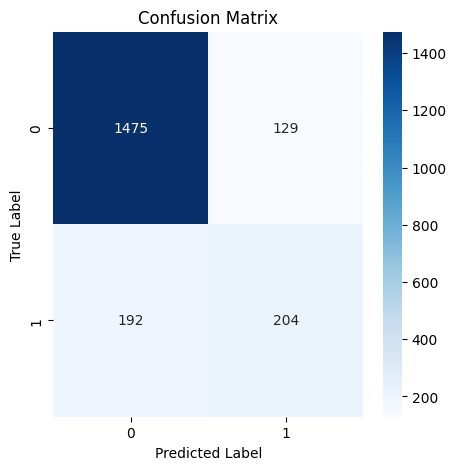

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Performance Metrics

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Train Performance Metrics
y_pred_train = dt.predict(X_train)
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Train Recall: ", recall_score(y_train, y_pred_train))
print("Train F1 Score: ", f1_score(y_train, y_pred_train))

#Test Performance Metrics
print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print("Test Precision: ", precision_score(y_test, y_pred))
print("Test Recall: ", recall_score(y_test, y_pred))
print("Test F1 Score: ", f1_score(y_test, y_pred))


Train Accuracy:  0.894
Train Precision:  0.8144329896907216
Train Recall:  0.6258379037172456
Train F1 Score:  0.7077877325982082
Test Accuracy:  0.8395
Test Precision:  0.6126126126126126
Test Recall:  0.5151515151515151
Test F1 Score:  0.5596707818930041


# Random Forest 

In [11]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Training model
rf = RandomForestClassifier(n_estimators=1000, max_depth=10)
rf.fit(X_train, y_train)

# Predicting values
y_pred = rf.predict(X_test)

### Confusion Matrix

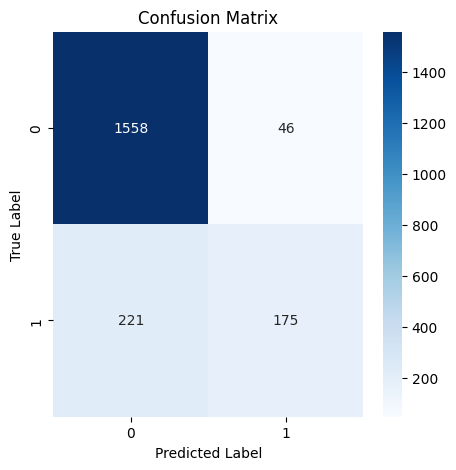

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Performance Metrics

In [13]:
# Comparision of Decision Tree and Random Forest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Train Performance Metrics
y_pred_train = rf.predict(X_train)
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Train Recall: ", recall_score(y_train, y_pred_train))
print("Train F1 Score: ", f1_score(y_train, y_pred_train))

#Test Performance Metrics
print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print("Test Precision: ", precision_score(y_test, y_pred))
print("Test Recall: ", recall_score(y_test, y_pred))
print("Test F1 Score: ", f1_score(y_test, y_pred))

Train Accuracy:  0.89725
Train Precision:  0.9398496240601504
Train Recall:  0.5332114564290067
Train F1 Score:  0.6804043545878693
Test Accuracy:  0.8665
Test Precision:  0.7918552036199095
Test Recall:  0.44191919191919193
Test F1 Score:  0.5672609400324149
